<a href="https://colab.research.google.com/github/Jungjee/INTERSPEECH2023_T6/blob/main/IS2023_tutorial_T6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



<img src="https://interspeech2023.org/wp-content/uploads/2021/12/Interspeech2023-Stacked-Colour-1030x411.png" alt="IS2023" width=350>


# Welcome

This is the hands-on notebook for Interspeech 2023 tutorial:
```
T6. Advances in Audio Anti-spoofing and Deepfake Detection using Graph Neural Networks and Self-supervised Learning

August 20, 2023
```


Presenter: [Jee-weon Jung](https://jungjee.github.io), [Hye-jin Shim](), [Hemlata Tak](), and [Xin Wang](https://researchmap.jp/wangxin?lang=en)

### All materials, including the slides for lecture are accessible [here](https://github.com/Jungjee/INTERSPEECH2023_T6)



# Preparation

We need to install a few packages and download a few supporting code snippets.


## Environment setup

In [ ]:
# Let's stick on to pip for now and add as many modules as possible with minor versions

# It seems that installing Pytorch is time consuming and troublesome
# Maybe we can stick to the default.
# Successfully installed nvidia-cublas-cu11-11.10.3.66 nvidia-cuda-nvrtc-cu11-11.7.99 nvidia-cuda-runtime-cu11-11.7.99 nvidia-cudnn-cu11-8.5.0.96 torch-1.13.1 torchaudio-0.13.1
# WARNING: The following packages were previously imported in this runtime:
#   [torch]
# You must restart the runtime in order to use newly installed versions.
!pip install torch==1.13.1 torchaudio==0.13.1


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 985.9 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 67.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 43.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 64.8 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.0.1+cu118
    Uninstalling torch-2.0.1+cu118:
      Successfully uninstalled torch-2.0.1+cu118
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 2.0.2+cu118
    Uninstalling torchaudio-2.0.2+cu118:
      Successfully uninstalled torchaudio-2.0.2+cu118
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency 

In [ ]:
# Pytorch version check
import torch
print(torch.__version__)
print(torch.cuda.is_available())

1.13.1+cu117
False


## Download Toy Data

In [ ]:
# To editors: you can add your own network storage
!echo "Download external zip file"
!wget --quiet --show-progress -O IS2023-tutorial.zip https://www.dropbox.com/sh/5l52sy0h5ayfpm9/AAAZU5MPU905oN_HPO9LU5yZa
!echo "Unzip files"

# if you are on Colab, unzip to this directory
!unzip -q -o IS2023-tutorial.zip -x / -d /content
!if [ -d "/content/session1" ]; then echo "Done"; else echo "Please contact with the author"; fi

# if you are running notebook using your own jupyter server
#  change the path
#!unzip -q -o IS2023-tutorial.zip -x / -d ./
#!if [ -d "./session1" ]; then echo "Done"; else echo "Please contact with the author"; fi



Download external zip file
IS2023-tutorial.zip 100%[===================>]  52.55M  7.02MB/s    in 9.9s    
Unzip files
Done


## Load Python packages


In [ ]:
# If you run the notebook on your own jupyter servers,
# please install the following dependency in advance

# If you run it on Google Colab, they are already available
from __future__ import absolute_import
from __future__ import print_function

import os
import sys
import random

import numpy as np
import scipy
import scipy.io.wavfile
import librosa
import soundfile as sf

import pandas as pd
import tqdm

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('text', usetex=False)

from os.path import join, isdir
import IPython

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

print(torch.__version__)

1.13.1+cu117


In [ ]:
# version used when creating this notebook
assert matplotlib.__version__ == '3.7.1'
assert np.__version__ == '1.22.4'
assert pd.__version__ == '1.5.3'
assert scipy.__version__ == "1.10.1"

AssertionError: ignored

In [ ]:
# global configuration

# default figure size
g_figsize = (5, 3)

# First session

## Introduction to speech anti-spoofing

In [ ]:
# Load customized functions
sys.path.append('/content/session1')
from plot_tools import plot_API
from plot_tools import plot_lib
from data_io import wav_tools


## Evaluation metric - EER

We explain the metric called equal error rate (EER) in this section. This section is a slightly shortened version of this [Jupyter notebook](https://github.com/nii-yamagishilab/project-NN-Pytorch-scripts/blob/master/tutorials/b2_anti_spoofing/chapter_a0_EER.ipynb).

There are many useful papers on EER. See paper (Leeuwen 2007) that explains EER in the context of speaker verification.



### False rejection and false accceptance

We focus on binary classification tasks. A sample with a Positive class label may be misclassified as Negative, or a sample with a Negative class label may be misclassified as True. See more on [Wikipedia](https://en.wikipedia.org/wiki/False_positives_and_false_negatives).

Let's ignore various ways to call the two types of errors and simply define them for CM in this way: given an audio sample with a class label, a CM produces a score $s$ and compares it with a threshold $\tau_{\text{cm}}$. The score indicates how likely the sample is **bona fide**.


The CM makes two types of errors:
* False Acceptance (FA): the data is classied as being bonafide (i.e., $s > \tau_{\text{cm}}$), but the data is actually spoofed.
* False Rejection (FR): the data is classied as being spoof (i.e., $s < \tau_{\text{cm}}$), but the data is actually bona fide.


Given a test data set that includes spoofed samples $\mathrm{S
}_\text{spoof}$ and bona fide samples $\mathrm{S}_\text{bona}$, a CM produced one score for each sample. We can compute how many FA and FR the CM made.
* FA:  $\sum_{s_i\in\mathrm{S}_{\text{spoof}}}\mathrm{1}({s_i > \tau_{\text{cm}}})$
* FR: $\sum_{s_i\in\mathrm{S}_{\text{bona}}}\mathrm{1}({s_i < \tau_{\text{cm}}})$

where $\mathrm{1}$ is an indicator function.


Let $|\mathrm{S}_{\text{spoof}}|$ and $|\mathrm{S}_{\text{bona}}|$ be the true number of spoofed and bona fide samples in the test set, respectively. We can compute the rate FA (FAR) and FR (FRR) as

$\begin{align}
{P}_{\text{FAR}}(\tau_{\text{cm}}) &\approx \frac{1}{|\mathrm{S}_{\text{spoof}}|} \sum_{s_i\in\mathrm{S}_{\text{spoof}}}\mathrm{1}({s_i > \tau_{\text{cm}}}) \\
{P}_{\text{FRR}}(\tau_{\text{cm}}) &\approx \frac{1}{|\mathrm{S}_{\text{bona}}|} \sum_{s_i\in\mathrm{S}_{\text{bona}}}\mathrm{1}({s_i < \tau_{\text{cm}}}) \\
\end{align}$

Notice that both ${P}_{\text{FAR}}(\tau_{\text{cm}})$ and ${P}_{\text{FRR}}(\tau_{\text{cm}})$ are functions of the threshold $\tau_{\text{cm}}$. If the value of the threshold changes, FAR and FRR change.

### Example of FAR and FRR

Let's check the example.

Let's assume that the scores follow Gaussian distributions. We get some scores from two Gaussian distributins (one for spoofed and one for boan fide) and compute the FAR and FRR.

In [ ]:
# generate 10000 samples for each of the spoofed and bona fide classes.
num_sample = 10000
# assuming that the mean of two distributions are separated by this value
mean_distance = 3

# threshold \tau_cm
threshold = -0.5

# suppose that the scores are Gaussian distributed
scores_spoof = np.random.randn(num_sample) - mean_distance / 2
scores_bona = np.random.randn(num_sample) + mean_distance / 2

We can now compute FAR and FRR

In [ ]:
def compute_far_frr(scores_bona: np.array,
                    scores_spoof: np.array,
                    threshold: float) -> tuple[float, float]:
    '''
    Compute FAR and FRR given scores and threshold.

    scores_bona        : np.array, scores of bona fide samples
    scores_spoof       : np.array, scores of spoofed samples
    threshold          : float, threshold for classification

    far                : float, far
    frr                : float, frr
    '''
    # compute FAR
    # we count the number of spoofed samples whose scores are higher than threshold
    fa = np.sum(scores_spoof > threshold)
    # then, divide it by the number of true spoofed samples
    far = fa / len(scores_spoof)

    # compute FRR
    # we count the number of bona fide samples whose scores are lower than threshold
    fr = np.sum(scores_bona < threshold)
    # then, divide it by the number of true spoofed samples
    frr = fr / len(scores_bona)
    return far, frr

far, frr = compute_far_frr(scores_bona, scores_spoof, threshold)
print('FAR: {:.2f} %'.format(far * 100))
print('FRR: {:.2f} %'.format(frr * 100))

FAR: 15.83 %
FRR: 2.22 %



Let's write a function to plot the histograms and the threshold



In [ ]:
def plot_scores_far_frr(scores_bona: np.array,
                        scores_spoof: np.array,
                        threshold: float):
    '''
    Plot score histograms and annotate the FAR and FRR

    scores_bona        : np.array, scores of bona fide samples
    scores_spoof       : np.array, scores of spoofed samples
    threshold          : float, threshold for classification
    '''


    # get the score range
    range = [min([scores_spoof.min(), scores_bona.min()]),
            max([scores_spoof.max(), scores_bona.max()])]

    # compute the histograms
    spoof_counts, spoof_bins = np.histogram(scores_spoof, bins=100, range=range)
    bona_counts, bona_bins = np.histogram(scores_bona, bins=100, range=range)

    # plot the score histogram
    fig, axis = plot_API.plot_API(
        [scores_bona, scores_spoof], plot_lib.plot_hist,
        'single', {'figsize': g_figsize,
                'xlabel': 'Score value', 'ylabel': 'Score histogram',
                'subplot':
                    [{'plot_hist': {'bins': 100, 'histtype': 'step', 'range': range, 'color': 'b'}},
                    {'plot_hist': {'bins': 100, 'histtype': 'step', 'range': range, 'color': 'r'}}],
                    'legend': {'labels': ['bonafide', 'spoof']}})

    # plot the threshold
    ylim = axis.get_ylim()
    axis.plot([threshold, threshold], [ylim[0], ylim[1]], linestyle='--', color='gray')
    axis.text(threshold, ylim[1], 'threshold = {:.2f}'.format(threshold))

    # fill the region for FA and FR
    fa_region = np.argwhere(spoof_bins[:-1] > threshold)[:, 0]
    fr_region = np.argwhere(bona_bins[:-1] < threshold)[:, 0]

    if len(fa_region):
        axis.fill_between(spoof_bins[fa_region], 0, spoof_counts[fa_region], color='r', alpha=0.1)
    if len(fr_region):
        axis.fill_between(bona_bins[fr_region], 0, bona_counts[fr_region], color='b', alpha=0.1)

    # compute FAR and FRR
    far, frr = compute_far_frr(scores_bona, scores_spoof, threshold)

    # add annotation for FA and FR
    # we need to compute the location to place the letter FA and FR
    #  you can define other functions. we use weighted sum
    if len(fa_region):
        xloc = ((spoof_bins[fa_region] * spoof_counts[fa_region]) / spoof_counts[fa_region].sum()).sum()
        yloc = spoof_counts[fa_region].mean()
        axis.text(xloc, yloc, 'FA', color='r');

    if len(fr_region):
        xloc = ((bona_bins[fr_region] * bona_counts[fr_region]) / bona_counts[fr_region].sum()).sum()
        yloc = bona_counts[fr_region].mean()
        axis.text(xloc, yloc, 'FR', color='b');

    axis.set_title('FAR: {:.2f} %, FRR: {:.2f} %'.format(far * 100, frr * 100))
    return fig, axis

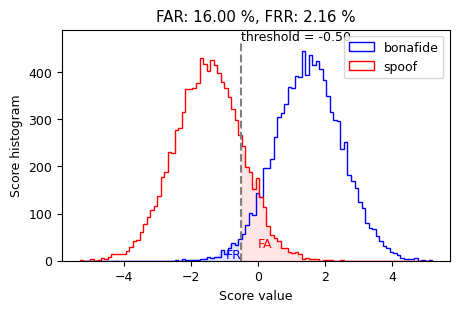

In [ ]:
fig, axis = plot_scores_far_frr(scores_bona, scores_spoof, threshold)

The FAR and FRR change according to the threshold.

Let's plot that.

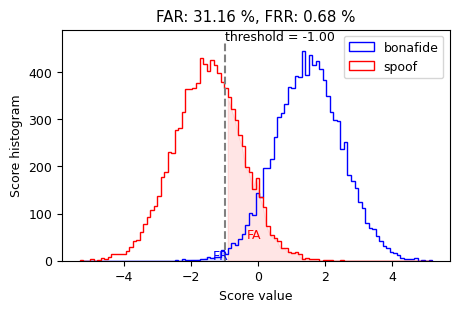

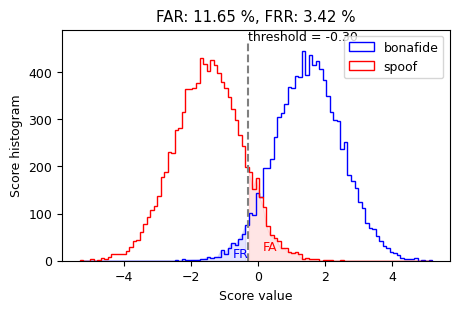

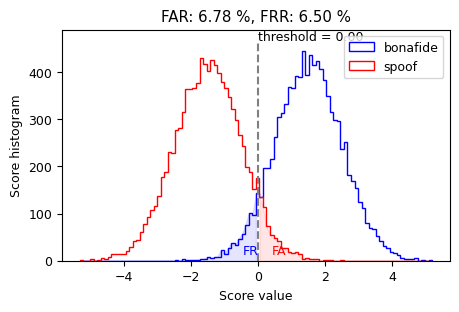

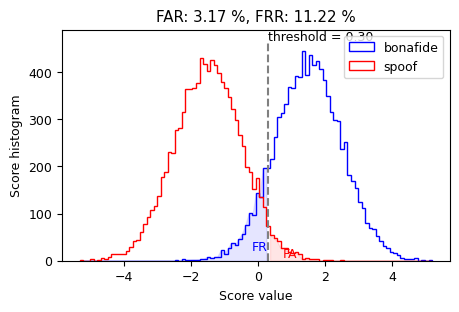

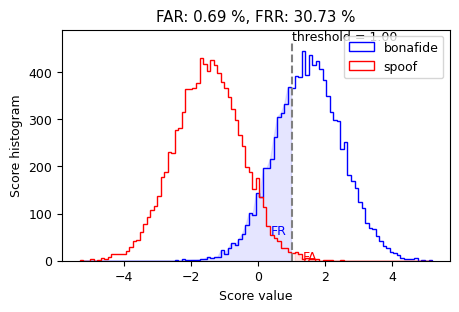

In [ ]:
# let's try these following thresholds
thresholds = [-1.0, -0.3, 0, 0.3, 1.0]

for threshold in thresholds:
    fig, axis = plot_scores_far_frr(scores_bona, scores_spoof, threshold)

### DET curve

For the score distributions above, we can see that when the threshold moves to the right hand side, the FAR decreases while the FRR increases. In most cases, there is a trade-off between FAR and FRR.

The threshold value can be $(-\infty, +\infty)$, but for a set with $M$ scores, we only need $M+1$ thresholds. For example, for spoofed and bona fide sample scores $\{0.1, 0.5\}\cup\{0.7, 0.8\}$, $\tau_{\text{cm}}=0.51$ or $\tau_{\text{cm}}=0.69$ give the same results.

```sh

   0.1      0.5   0.7  0.8
   |         |     |    |
---------------------------------> score
               ^  
               |
        threshold = 0.61
```

Using thresholds, for example, $\tau_{\text{cm}}\in\{0.09, 0.49, 0.69, 0.79, 0.81\}$ are sufficient to summarize the FAR and FRR on this small data set.


This is the idea of the implementation used by many tools. Here is one that returns FAR, FRR, and thresholds given two sets of scores.


In [ ]:

def compute_det_curve(scores_bona: np.array,
                      scores_spoof: np.array) -> tuple[np.array, np.array, np.array]:
    """ frr, far, thresholds = compute_det_curve(scores_bona, scores_spoof)

    From ASVspoof official package https://www.asvspoof.org/resources/tDCF_python_v2.zip
    input
    -----
      scores_bona      : np.array, (#num_bonafide, ), score of bonafide data
      scores_spoof     : np.array, (#num_spoof, ), score of spoofed data

    output
    ------
      frr              : np.array, (M+1, ), false rejection rates measured at different thresholds
      far              : np.array, (M+1, ), false acceptance rates measured at different thresholds
      thresholds       : np.array, (M+1, ), thresholds used to compute frr and far

      where M = len(scores_bona) + len(scores_spoof) + 1
    """
    # Total number of scores
    n_scores = scores_bona.size + scores_spoof.size

    # Concatenate the two sets of scores
    all_scores = np.concatenate((scores_bona, scores_spoof))

    # Concatenate the corresponding labels.
    # We use 1 for bona fide, 0 for spoof
    labels = np.concatenate((np.ones(scores_bona.size),
                             np.zeros(scores_spoof.size)))

    # Sort scores
    indices = np.argsort(all_scores, kind='mergesort')

    # Sort labels according to the scores
    labels = labels[indices]

    # Compute false rejection and false acceptance rates
    # It is simply based on counting
    bona_trial_sums = np.cumsum(labels)
    spoof_trial_sums = (scores_spoof.size -
                            (np.arange(1, n_scores + 1) - bona_trial_sums))
    #
    frr = np.concatenate((np.atleast_1d(0), bona_trial_sums/scores_bona.size))

    # false rejection rates
    far = np.concatenate((np.atleast_1d(1),
                          spoof_trial_sums / scores_spoof.size))

    # false acceptance rates
    thresholds = np.concatenate((np.atleast_1d(all_scores[indices[0]] - 0.001),
                                 all_scores[indices]))

    # Thresholds are the sorted scores
    return frr, far, thresholds

Note that `compute_det_curve` and `compute_far_frr` provide different APIs. The former sweeps the threshold and compute all the FAR and FRR values. The latter computes FAR and FRR at a single threshold. The former uses a more clever implementation (i.e., sorting and counting).

Now we can get all the possible FAR, FRR from the sample test sets.


In [ ]:
# call the API
frr, far, thresholds = compute_det_curve(scores_bona, scores_spoof)

# plot the figure
fig, axis = plot_API.plot_API(np.stack([far * 100, frr * 100], axis=1),
                              plot_lib.plot_signal, 'single',
                               {'figsize': (5,5), 'xlabel': 'FAR (%)', 'ylabel': 'FRR (%)'})
axis.grid(visible=True)

NameError: ignored

The trade-off between FRR and FAR is obvious.

The curve resides near the left-bottom corner, which is not easy to see.

Let's warp the x and y axies using a probit function. This is the idea of Detection Error Trade-off (DET) curve (Martin 1997). A good advantage is that will make the curve straight and easy to see!

In [ ]:
from scipy import special as scipy_special
def probit(x):
    """ probit function to scale the axis
    based on __probit__(p) see [3]
    https://
    projets-lium.univ-lemans.fr/sidekit/_modules/sidekit/bosaris/detplot.html
    """
    return np.sqrt(2) * scipy_special.erfinv(2.0 * x - 1)

def plot_det_curve(scores_bona: np.array,
                   scores_spoof: np.array,
                   ticks: np.array = np.array([0.01, 0.05, 0.1, 0.2, 0.4])):
    '''
    Plot DET curve

    scores_bona      : np.array, (#num_bonafide, ), score of bonafide data
    scores_spoof     : np.array, (#num_spoof, ), score of spoofed data
    ticks            : np.array, values to annotate on the axes
                       default [0.01, 0.05, 0.1, 0.2, 0.4]
    '''
    # compute FAR and FRR
    far, frr, thresholds = compute_det_curve(scores_bona, scores_spoof)

    # warp the values
    far_warped = probit(far)
    frr_warped = probit(frr)

    # for plotting, let's show the original FAR and FRR values
    xticks = ticks
    yticks = xticks

    xtick_labels = ['{:.2f}'.format(x * 100) for x in xticks]
    ytick_labels = ['{:.2f}'.format(x * 100) for x in yticks]

    xticks = probit(xticks)
    yticks = probit(yticks)

    fig, axis = plot_API.plot_API(
        np.stack([far * 100, frr * 100], axis=1),
        plot_lib.plot_signal, 'single',
         {'figsize': (5,5), 'xlabel': 'FAR (%)', 'ylabel': 'FRR (%)'})
    axis.grid(visible=True)
    axis.plot(far_warped, frr_warped, color = 'k')
    axis.set_xlabel('FAR (%)')
    axis.set_ylabel('FRR (%)')
    axis.grid(visible=True)
    axis.set_xticks(xticks)
    axis.set_yticks(yticks)
    axis.set_xticklabels(xtick_labels)
    axis.set_yticklabels(ytick_labels)
    axis.set_xlim(probit(ticks.min()), probit(0.5))
    axis.set_ylim(probit(ticks.min()), probit(0.5))
    return fig, axis

Text(0.5, 1.0, 'DET curve')

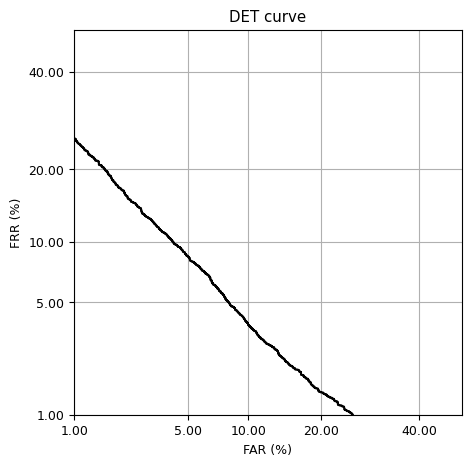

In [ ]:
fig, axis = plot_det_curve(scores_bona, scores_spoof)
axis.set_title('DET curve')

### EER

How do we summary the information of the DET curve into one number? EER is one choice.

Its definition may differ in other literatures, but one used by this community is the simply $\text{EER} = \frac{\text{FAR}(\tau_{\text{EER}}) + \text{FAR}(\tau_{\text{EER}})}{2}$, where $\tau_{\text{EER}} = \arg\min_\tau |\text{FAR}(\tau) - \text{FRR}(\tau)|$.

In [ ]:
def compute_eer(scores_bona: np.array, scores_spoof: np.array) -> tuple[float, float]:
    """ eer, eer_threshold = compute_det_curve(scores_bona, scores_spoof)

    input
    -----
      scores_bona      : np.array, (#num_bonafide, ), score of bonafide data
      scores_spoof     : np.array, (#num_spoof, ), score of spoofed data

    output
    ------
      eer:              scalar,  value of EER
      eer_threshold:    scalar,  value of threshold corresponding to EER
    """
    # get FRR and FAR arrays
    frr, far, thresholds = compute_det_curve(scores_bona, scores_spoof)

    # find the index of the \tau_EER
    abs_diffs = np.abs(frr - far)
    min_index = np.argmin(abs_diffs)

    # threshold for EER
    eer_threshold = thresholds[min_index]

    # EER
    eer = np.mean((frr[min_index], far[min_index]))
    return eer, eer_threshold

In [ ]:
# we can compute EER using this function
eer, threshold_eer = compute_eer(scores_bona, scores_spoof)

# let's plot the DET and annotate the EER on the figure
# writ a simple wrapper over plot_det_curve
def plot_det_curve_eer(scores_bona: np.array,
                       scores_spoof: np.array,
                       ticks: np.array = np.array([0.01, 0.05, 0.1, 0.2, 0.4])):
    '''
    Plot DET curve and annotate EER

    scores_bona      : np.array, (#num_bonafide, ), score of bonafide data
    scores_spoof     : np.array, (#num_spoof, ), score of spoofed data
    ticks            : np.array, values to annotate on the axes
                       default [0.01, 0.05, 0.1, 0.2, 0.4]
    '''
    # plot the DET curve
    fig, axis = plot_det_curve(scores_bona, scores_spoof)

    # compute the EER
    eer, threshold_eer = compute_eer(scores_bona, scores_spoof)


    axis.set_title('DET curve')
    xlim = axis.get_xlim()
    axis.text(probit(eer), probit(eer), '  EER {:.2f}%'.format( eer * 100))
    axis.scatter(probit(eer), probit(eer), s=100.0, marker='o', facecolor='none', edgecolor='r')
    axis.plot([xlim[0], xlim[1]], [xlim[0], xlim[1]], color='grey', linestyle=':')
    return fig, axis

fig, axis = plot_det_curve_eer(scores_bona, scores_spoof)

NameError: ignored



Comments on $\text{EER}$:
* EER is not the only way to summary the information in the DET curve. More complicated metrics include Cllr and related metrics (Leeuwen 2007).
* In the context of ASVspoof, where an ASV system is mounted behind the CM, a spoofed data that fools the CM may not sounds like the target speaker, hence being rejected. To take both ASV and CM into consideration, we have tandem Detection Cost Function (t-DCF). Please check (Kinnunen 2020) for more details. This is also the official metric used by ASVspoof challenges.
* EER has many interesting properties:
    * Since EER is based on sorting and counting, the EER will not change if we use a monotonic increasing function to transform all the scores.
    * Given $\text{EER}_1$ on test set 1 and $\text{EER}_2$ on test set 2, the $\text{EER}$ of test sets 1 + 2 is not a simple weighted sum of $\text{EER}_1$ and $\text{EER}_2$.
    * See more examples about the above properties in this [Jupyter notebook](https://github.com/nii-yamagishilab/project-NN-Pytorch-scripts/blob/master/tutorials/b2_anti_spoofing/chapter_a0_EER.ipynb)

A brief summary:
* Anti-spoofing is usually formulated as a binary classification task.
* It suffers from false acceptance (i.e., spoofed is classified as bona fide) and false rejection (i.e., bona fide is classified as spoofed)
* False acceptance rate (FAR) and false rejection rate (FRR) can be computed by counting and sorting.
* DET curve is a convenient way to plot the trade-off between FAR and FRR.
* EER is the error rate when a threshold is chosen so that FAR is almost identical to FRR.
* EER is not the only choice for measuing CM performance, but it is simple.

Useful functions:
* Compute FAR and FRR by sweeping thresholds `far, frr, threholds = compute_det_curve(scores_bona, scores_spoof)`
* Plot DET curve `plot_det_curve(scores_bona, scores_spoof)`
* Compute EER and the threshold `eer, threshold_eer = compute_eer(scores_bona, scores_spoof)`


## Toy example on building CM

Let's build a toy (non-trainable) CM on **a subset** of the [ASVspoof2019 LA training set](https://www.asvspoof.org/index2019.html).

The toy example is only for demonstration. It is not intended to be used to build a full-fledged CM.

In [ ]:
# We use functions below to load the audio and "see" the audio
def load_audio(audio_path: str) -> tuple[np.array, int]:
    '''
    Load audio waveform

    audio_path       : path to the audio file
    wav_output       : waveform data, (#length, )
    sr               : sampling rate, int
    '''
    wav, sr = librosa.load(audio_path, sr=None)
    return wav, sr

def audio_show(audio_path: str, flag_wav: bool = False) -> None:
    '''
    Load audio into an audio playing button and show spectrogram

    audio_path       : path to the audio file
    flag_wav         : whether plot waveform in time domain? default False
    '''
    # load audio
    data, sr = load_audio(audio_path)

    # display the basename
    data_basename = os.path.basename(audio_path)

    # plot spectrogram
    plot_API.plot_API(
        data, plot_lib.plot_spec, 'single',
         {'plot_spec': {'sampling_rate': sr}, 'figsize': g_figsize,
          'title': data_basename})

    # plot waveform if nessary
    if flag_wav:
        plot_API.plot_API(data, plot_lib.plot_signal, 'single', {'figsize': g_figsize})

    # display the audio playing button
    IPython.display.display(data_basename)
    IPython.display.display(IPython.display.Audio(data, rate=sr, normalize=False))
    return

### Protocol and prepare data path

For convenience, let's load the training set protocol.


In [ ]:
# Protocol should have been downloaded to this path
sec1_protocol = '/content/session1/data/LA/ASVspoof2019.LA.cm.train.trl.txt'

# Load the protocol (which shows the)
protocol = pd.read_csv(sec1_protocol, names = ['speaker', 'trial', '-', 'attack', 'label'], sep = ' ')
protocol

# The five columns of the ptocol are speaker, utterance name (trial),
#  a dummy column (-), attack name, label (bonafide or spoof)

,speaker,trial,-,attack,label
0,LA_0079,LA_T_1138215,-,-,bonafide
1,LA_0079,LA_T_1271820,-,-,bonafide
2,LA_0079,LA_T_1272637,-,-,bonafide
3,LA_0079,LA_T_1276960,-,-,bonafide
4,LA_0079,LA_T_1341447,-,-,bonafide
...,...,...,...,...,...
25375,LA_0098,LA_T_9717580,-,A06,spoof
25376,LA_0098,LA_T_9779814,-,A06,spoof
25377,LA_0098,LA_T_9783312,-,A06,spoof
25378,LA_0098,LA_T_9839348,-,A06,spoof


In [ ]:
# Data should have been downloaded to this directory.
sec1_prjdir = '/content/session1/data/LA/ASVspoof2019_LA_train/flac/'

### Very first analysis

Let's check bona fide audio data of one speaker and spoofed data using one attacking method.



In [ ]:
# Let's speak this speaker
speaker_id = 'LA_0082'
# Let's analysis attack A02
attack = 'A02'

# Get the data list from the speaker
# (We use pandas functions to query the protocol. See https://pandas.pydata.org/)
data_pd = protocol.query('speaker == "{:s}"'.format(speaker_id))

# Sample a bonafide utterance from this speaker
bonafide_name = data_pd.query('label == "bonafide"').sample(n=1, random_state=100)['trial'].iloc[0]

# Sample a spoof utterance from this speaker and attack
spoofed_name = data_pd.query('attack == "{:s}"'.format(attack)).sample(n=1, random_state=100)['trial'].iloc[0]

'Bona fide sample from speaker LA_0082'

'LA_T_3171621.flac'

'Spoofed sample from speaker LA_0082'

'LA_T_5417872.flac'

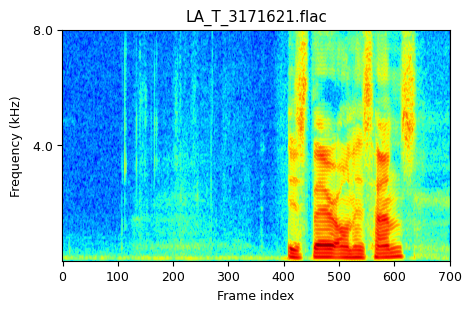

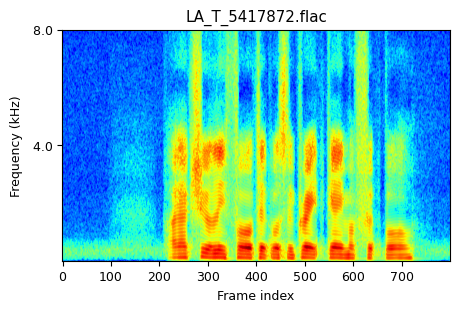

In [ ]:
# the first one is a bona fide sample
bonafide_audio_path = os.path.join(sec1_prjdir,  bonafide_name + '.flac')
IPython.display.display('Bona fide sample from speaker {:s}'.format(speaker_id))
audio_show(bonafide_audio_path)

# the second one is a spoofed sample
spoofed_audio_path = os.path.join(sec1_prjdir,  spoofed_name + '.flac')
IPython.display.display('Spoofed sample from speaker {:s}'.format(speaker_id))
data_spoofed = audio_show(spoofed_audio_path)

It seems that the spoofed sample have low spectral energy above ~5.0 kHz of the voiced sounds (segments with ripple-like horizontal bars).

Let's take a closer look at one frame from each spectrogram.

That may be a good discriminative feature for the first trial.

Let's define some functions to extract that feature.

### Toy front end ver1.0

We will use basic signal processing tools to build this front end:

```sh
waveform -> pick frames with high energy -> spectrum amplitude
```

In [ ]:
def spec_amp(audio_data: np.array,
             fft_bins: int = 4096,
             frame_shift: int = 40,
             frame_length: int = 240) -> np.array:
    '''
    Compute spectral amplitude (dB)

    audio_data         : np.array, waveform data, (#length, )
    fft_bins           : int, number of fft bins, default 4096
    frame_shift        : int, frame shift in terms of sampling points number, default 40
    frame_length       : int, frame length in terms of sampling points number, default 240
    spec_amp           : np.array, spectral amplitude, (#frame, #bins)
                         #bins = fft_bins // 2 + 1 if fft_bins is an even number
    '''
    # compute STFT
    _, _, cfft = scipy.signal.stft(
        audio_data,
        nfft = fft_bins,
        noverlap = frame_length - frame_shift,
        nperseg = frame_length)

    # compute spectral amplitude
    mag = np.power(np.power(np.real(cfft),2) + np.power(np.imag(cfft),2), 0.5)

    # linear to spectrogram (dB)
    amp = 20 * np.log10(mag + np.finfo(np.float32).eps)
    return amp.T

def vad(audio_data: np.array,
        sampling_rate: int = 16000) -> np.array:
    '''
    Voice activity detection based on algoritm presented in
    Tomi Kinnunen, and Haizhou Li.
    An Overview of Text-Independent Speaker Recognition: From Features to
    Supervectors. Speech Communication 52 (1).
    Elsevier: 12–40. doi:10.1016/j.specom.2009.08.009. 2010.

    audio_data         : np.array, waveform data, (#length, )
    sampling_rate      : int, sampling rate, default 16000

    output_audio_data  : np.array, waveform data, (#length, )
    '''

    # we will directly call the function. Please check the function for more details
    output, _ , _ = wav_tools.silence_handler(
        audio_data, sampling_rate, flag_only_startend_sil=False)
    return output

def front_end_v1(audio_data: np.array) -> np.array:
    '''
    Toy front end version 1.0
    We use spectrogram of high-enenrgy frames as acoustic features

    audio_data         : np.array, waveform data, (#length, )
    spec_amp           : np.array, spectral amplitude, (#frame, 2049)
    '''
    return spec_amp(vad(audio_data))

In [ ]:
# load two audios for sanity check
bonafide_data, sr = load_audio(bonafide_audio_path)
spoofed_data, sr =  load_audio(spoofed_audio_path)

In [ ]:
# This is the spectrogram after removing low-energy regions
bonafide_spec_data = front_end_v1(bonafide_data)
spoofed_spec_data = front_end_v1(spoofed_data)

# You can compare the differences before and after removing low-energy regions
# here we skip it
if False:
    # This is the spectrogram without removing low-energy regions
    spoofed_spec_data_ = spec_amp(spoofed_data)
    # You can compare the different through this function
    plot_API.plot_API2([spoofed_spec_data.T, spoofed_spec_data_.T],
                    [plot_lib.plot_imshow, plot_lib.plot_imshow], 'v',
                    {'figsize': g_figsize})

(<Figure size 500x300 with 1 Axes>,
 <Axes: xlabel='Frame index', ylabel='Frequency (kHz)'>)

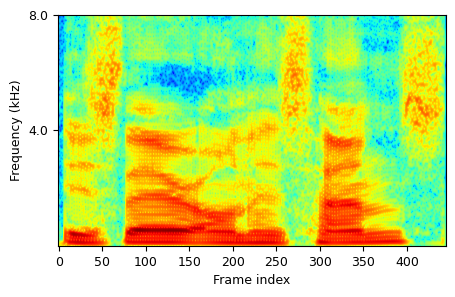

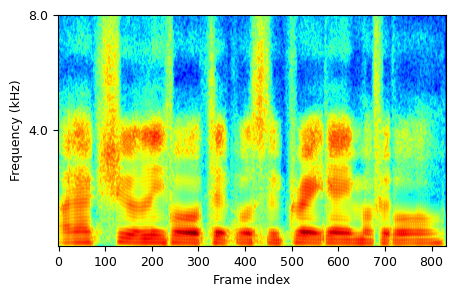

In [ ]:
sampling_rate = 16000
num_freq_bins = (spoofed_spec_data.shape[1] - 1) * 2
yticks = [num_freq_bins//4, num_freq_bins//2]
yticklabels = [x / num_freq_bins * (sampling_rate) for x in yticks]
yticklabels = ['{:1.1f}'.format(x  / 1000) for x in yticklabels]
plot_config = {'figsize': g_figsize, 'xlabel': 'Frame index', 'ylabel': 'Frequency (kHz)',
               'yticks': yticks, 'yticklabels': yticklabels}

# plot spectrogram
plot_API.plot_API(bonafide_spec_data.T, plot_lib.plot_imshow, 'single', plot_config)
plot_API.plot_API(spoofed_spec_data.T, plot_lib.plot_imshow, 'single', plot_config)


We use the spectral amplitude for back end scoring.

### Toy back end ver1.0

Given the spectrogram as acoustic features, we need to convert it into a score $S\in\mathbb{R}$.

In other words, the back end should be $f: \mathbb{R}^{N\times D} \rightarrow \mathbb{R}$, where $N$ and $D$ are the frame number and dimensions per frame of front end features.

Since the front-end features have varied length (i.e., $N$ varies across data), the first thing is to convert it into a fixed-length feature vector.

A simple idea is to take average over the frames.



(<Figure size 500x300 with 1 Axes>,
 <Axes: title={'center': 'Spectrum averaged over frames'}, xlabel='Frequency bin index', ylabel='Amplitude (dB)'>)

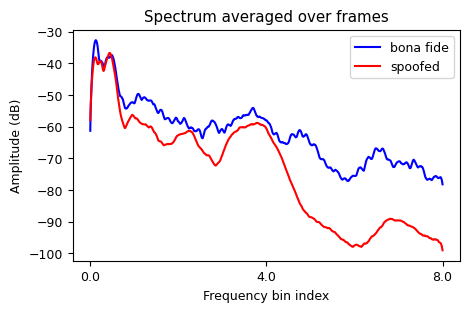

In [ ]:
# Let's look at the average using mean(axis=0)
bonafide_spec_mean = bonafide_spec_data.mean(axis=0)
spoof_spec_mean = spoofed_spec_data.mean(axis=0)


xticks = [0, num_freq_bins//4, num_freq_bins//2]
xticklabels = [x / num_freq_bins * (sampling_rate) for x in xticks]
xticklabels = ['{:1.1f}'.format(x  / 1000) for x in xticklabels]

plot_API.plot_API(
    [bonafide_spec_mean, spoof_spec_mean],
    plot_lib.plot_signal, 'single',
     {'figsize': g_figsize, 'xlabel': 'Frequency bin index',
       'xticks': xticks, 'xticklabels': xticklabels,
      'ylabel': 'Amplitude (dB)',
      'title': 'Spectrum averaged over frames',
      'subplot': [{'plot_signal': {'color': 'b'}}, {'plot_signal': {'color': 'r'}}],
      'legend': {'labels': ['bona fide', 'spoofed']}})

The differences are obvious in the high-frequency regions.

Why not use the average of frequency bins on the right half the curve as score $S$?

This is our toy back end

```sh
spectrogram -> average_over_time -> average_over_frequency_bins_above_middle
```

In [ ]:
def back_end_v1(spec_amp: np.array) -> float:
    '''
    Toy back end version 1.0

    We compute the average over time and average over frequency bins > 1200
    spec_amp           : np.array, spectral amplitude, (#frame, 2049)
    score              : float, score value
    '''

    # step1. merge variable length data to a fixed dimension vector
    utt_feature_data = spec_amp.mean(axis=0)

    # step2. compute the average score from high-frequency region
    dim = utt_feature_data.shape[0]
    score = utt_feature_data[dim // 2:].mean()
    return score

### Try toy CM ver1.0

We are ready to try the CM on the data.

In [ ]:
def cm_v1(audio_data: np.array) -> float:
    '''
    Toy CM version 1.0, based on front end 1.0 and back end 1.0

    audio_data         : np.array, waveform data, (#length, )
    score              : float, score value
    '''
    return back_end_v1(front_end_v1(audio_data))

Define a simple loop to score a set of bona fide and spoofed data.

In [ ]:
def sanity_check_single_speaker_attack(cm_model, speaker_id, attack,
                                       protocol = protocol, data_dir = sec1_prjdir):
    '''
    Get the samples for one speaker and one spoofing attack, score the data,
    and compute the results

    cm_model      : function that converts waveform (1D np.array) into score (float)
    speaker_id    : str, Id of the speaker
    attack        : str, Id of the attacking method

    bonafide_scores : np.array, 1D np.array, scores of bona fide data
    spoofed_scores  : np.array, 1D np.array, scores of spoofed data
    '''

    # Let's speak this speaker and this attack
    print("Try toy CM on speaker {:s}, compare bona fide and {:s}".format(speaker_id, attack))

    # Get the data list from the speaker
    # (We use pandas functions to query the protocol. See https://pandas.pydata.org/)
    data_pd = protocol.query('speaker == "{:s}"'.format(speaker_id))

    # Get the list of bona fide data
    bonafide_names = data_pd.query('label == "bonafide"')['trial'].to_list()

    # Get the list of spoofed data
    spoofed_names = data_pd.query('attack == "{:s}"'.format(attack))['trial'].to_list()

    # comptue the scores
    scores_bonafide = {}
    for filename in tqdm.tqdm(bonafide_names):
        # load audio
        data_bonafide, sr  = load_audio(os.path.join(data_dir,  filename + '.flac'))
        # compute score
        score_bonafide = cm_model(data_bonafide)
        # save score
        scores_bonafide[filename] = score_bonafide

    scores_spoof = {}
    for filename in tqdm.tqdm(spoofed_names):
        data_spoof , sr  = load_audio(os.path.join(data_dir,  filename + '.flac'))
        score_spoof = cm_model(data_spoof)
        scores_spoof[filename] = score_spoof

    # take the values out of the pandas
    scores_bonafide_array = np.array(list(scores_bonafide.values()))
    scores_spoof_array = np.array(list(scores_spoof.values()))

    # compute EER and get the threshold for EER
    _, eer_threshold = compute_eer(scores_bonafide_array, scores_spoof_array)
    # plot histograms and show FAR and FRR
    fig, axis = plot_scores_far_frr(scores_bonafide_array, scores_spoof_array, eer_threshold)
    # plot DET with EER
    fig, axis = plot_det_curve_eer(scores_bonafide_array, scores_spoof_array)

    return scores_bonafide_array, scores_spoof_array

#### Single speaker, single spoofing attack

Try toy CM on speaker LA_0082, compare bona fide and A02


100%|██████████| 196/196 [00:26<00:00,  7.51it/s]


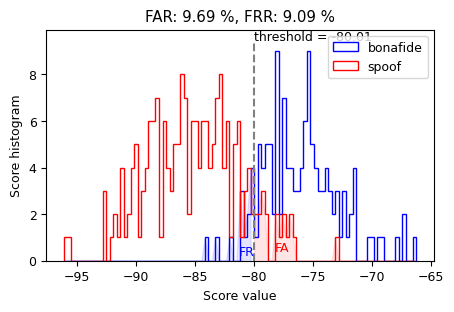

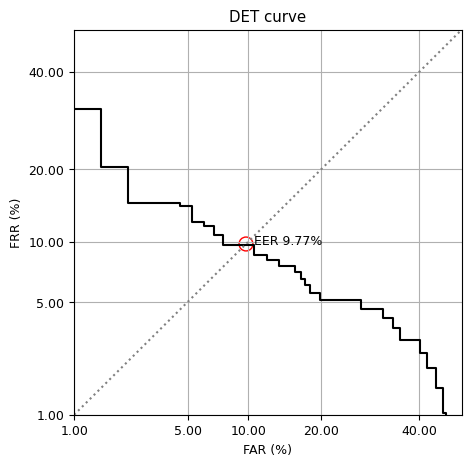

In [ ]:
# Let's speak this speaker
speaker_id = 'LA_0082'
# Let's analysis attack A02
attack = 'A02'

_, _ = sanity_check_single_speaker_attack(cm_v1, speaker_id, attack)

Notice that the difference between EER and FAR/FRR is not small.

The DET curve is also zigzag.

This is because the score set is small.

#### Another speaker, same spoofing attack

EER of 9% is not bad for a very naive CM.

Does the CM generalize to another speaker? Let's check.

In [ ]:
# Let's speak this speaker
speaker_id = 'LA_0087'
# Let's analysis attack A02
attack = 'A02'

_, _, = sanity_check_single_speaker_attack(cm_v1, speaker_id, attack)

Try toy CM on speaker LA_0087, compare bona fide and A02


 91%|█████████▏| 170/186 [00:22<00:02,  7.62it/s]


KeyboardInterrupt: ignored

Although EER 17% is not bad on another speaker, the degradation is obvious.

How about another spoofing attack?

#### Single speaker, another spoofing attack

In [ ]:
# Let's speak this speaker
speaker_id = 'LA_0082'
# Let's analysis attack A06
attack = 'A06'

_, _, = sanity_check_single_speaker_attack(cm_v1, speaker_id, attack)

Sadly, EER was around 50%. The CM does not work to detect another spoofing attack.

### Why toy CM cannot work?

We design the toy CM based on our observation from the comparison between the bona fide data and spoofed data from one speaker and one attack.

The artifacts may vary across different attacks.

Let's check the spoofing attack that was difficult to detect.

'Bona fide sample from speaker LA_0082'

'LA_T_3171621.flac'

'Spoofed sample from speaker LA_0082'

'LA_T_5339842.flac'

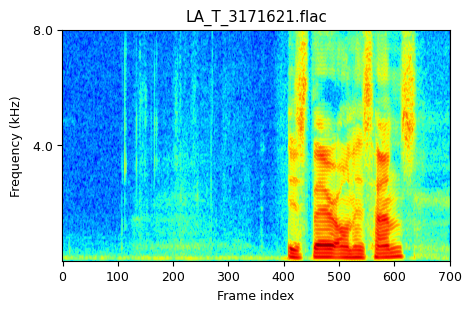

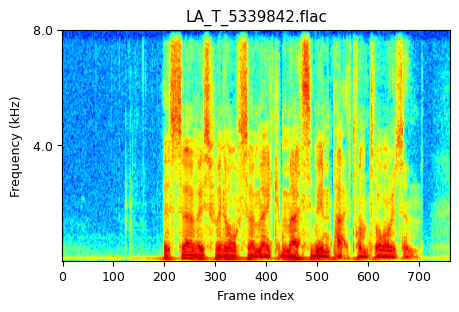

In [ ]:
# Let's speak this speaker
speaker_id = 'LA_0082'
# Let's analysis attack A02
attack = 'A06'

# Get the data list from the speaker
# (We use pandas functions to query the protocol. See https://pandas.pydata.org/)
data_pd = protocol.query('speaker == "{:s}"'.format(speaker_id))

# Sample a bonafide utterance from this speaker
bonafide_name = data_pd.query('label == "bonafide"').sample(n=1, random_state=100)['trial'].iloc[0]

# Sample a spoof utterance from this speaker and attack
spoofed_name = data_pd.query('attack == "{:s}"'.format(attack)).sample(n=1, random_state=100)['trial'].iloc[0]

# the first one is a bona fide sample
bonafide_audio_path = os.path.join(sec1_prjdir,  bonafide_name + '.flac')
IPython.display.display('Bona fide sample from speaker {:s}'.format(speaker_id))
audio_show(bonafide_audio_path)

# the second one is a spoofed sample
spoofed_audio_path = os.path.join(sec1_prjdir,  spoofed_name + '.flac')
IPython.display.display('Spoofed sample from speaker {:s}'.format(speaker_id))
data_spoofed = audio_show(spoofed_audio_path)

In [ ]:
# load two audios for sanity check
bonafide_data, sr = load_audio(bonafide_audio_path)
spoofed_data, sr =  load_audio(spoofed_audio_path)

# compute features
bonafide_spec_data = front_end_v1(bonafide_data)
spoof_spec_data = front_end_v1(spoofed_data)

# Let's look at the average using mean(axis=0)
bonafide_spec_mean = bonafide_spec_data.mean(axis=0)
spoof_spec_mean = spoof_spec_data.mean(axis=0)

xticks = [0, num_freq_bins//4, num_freq_bins//2]
xticklabels = [x / num_freq_bins * (sampling_rate) for x in xticks]
xticklabels = ['{:1.1f}'.format(x  / 1000) for x in xticklabels]

plot_API.plot_API(
    [bonafide_spec_mean, spoof_spec_mean],
    plot_lib.plot_signal, 'single',
     {'figsize': g_figsize, 'xlabel': 'Frequency bin index',
       'xticks': xticks, 'xticklabels': xticklabels,
      'ylabel': 'Amplitude (dB)',
      'ylim': (-102, -28),
      'title': 'Spectrum averaged over frames',
      'subplot': [{'plot_signal': {'color': 'b'}}, {'plot_signal': {'color': 'r'}}],
      'legend': {'labels': ['bona fide', 'spoofed']}})

Except the very high-frequency regions around the 2000th frequency bin, the differences between spoofed and bona fide spectra average is small.

Hence, the naive CM may not work if it look at the average over between bins 1000 and 2049.

### Try toy CM ver2.0

We now have an idea to improve -- we can focus more on the frequency bins around 2000.

We can simply do this by weighted sum of the frequency bins rather than simple average.

(<Figure size 500x300 with 1 Axes>,
 <Axes: xlabel='Frequency bin index', ylabel='Weight value'>)

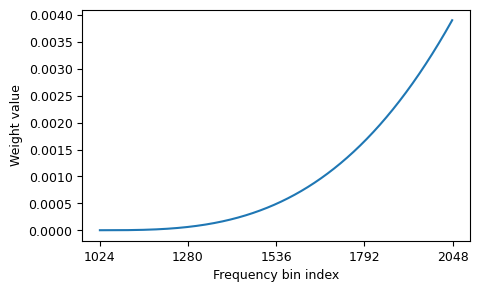

In [ ]:
# here is
number_bins = 2049 // 2
weights = np.power(np.linspace(0, 1, number_bins), 3)
weights = weights / weights.sum()

#
xticks = np.linspace(0, number_bins, 5, dtype=np.int32)
plot_API.plot_API(
    weights, plot_lib.plot_signal,'single',
     {'figsize': g_figsize, 'xlabel': 'Frequency bin index', 'ylabel': 'Weight value',
       'xticks': xticks, 'xticklabels': xticks + number_bins})

In [ ]:
def back_end_v2(spec_amp: np.array) -> float:
    '''
    Toy back end version 2.0

    We compute the average over time and average over frequency bins > 1200
    spec_amp           : np.array, spectral amplitude, (#frame, 2049)
    score              : float, score value
    '''

    # step1. merge variable length data to a fixed dimension vector
    utt_feature_data = spec_amp.mean(axis=0)

    # step2. number of bins to check
    dim = utt_feature_data.shape[0]

    # we only look at the second half of the feature vector
    start_bins = dim // 2
    bins_selected = utt_feature_data[start_bins:]

    # assign weight assining 1 to the high frequency bins
    weight = np.power(np.linspace(0, 1, len(bins_selected)), 3)

    # normalize the weight
    weight = weight / weight.sum()

    # weighted sum
    score = np.sum(bins_selected * weight)
    return score

def cm_v2(audio_data: np.array) -> float:
    '''
    Toy CM version 2.0, based on front end 1.0 and back end 2.0

    audio_data         : np.array, waveform data, (#length, )
    score              : float, score value
    '''
    return back_end_v2(front_end_v1(audio_data))


In [ ]:
# Let's speak this speaker
speaker_id = 'LA_0082'
# Let's analysis attack A06
attack = 'A06'

_, _, = sanity_check_single_speaker_attack(cm_v2, speaker_id, attack)


Can it work on attack 'A02'?

In [ ]:
# Let's speak this speaker
speaker_id = 'LA_0082'
# Let's analysis attack A06
attack = 'A02'

_, _, = sanity_check_single_speaker_attack(cm_v2, speaker_id, attack)


## Move to trainable and more complicated CMs

We have seen that the toy CMs do not generalize well. One challenge is that it is not easy to spot or extract the discriminative features based on our observations.

Two possible ways to go
1. CM by machine learning
   * Remember how we multiply a weight vector to the averaged spectrum amplitude in toy CM version 2.0. These weights can be learned from a training set using machine learning scheme.
   * We can replace the STFT spectral amplitude with trainable models such as convolution network, replace the average over frames with an attention mechanism, or replace the weighted sum of half of the spectral vector with a multi-layer perceptron.
   * We can design a so-called End-to-End system to directly convert waveform into a score.

2. CM with expert knowledge
   * Linguistics and forensic phoneticians may have better knowledge and tools to extract features and detect spoofed data. The paper by (Kirchhübel 2022) is one example.


This tutorial is on CM by machine learning. In Section 2, we will see how advanced graph neural networks can be used as a CM.
   


# Second session


## Introduction to Graph attention networks

## Graph attention layer

### Part 1. Attention calculation
First, node-wise multiplication and projection calculates the attention values for each edge.
1. pairwise_mul_nodes: multiplies any two nodes, resulting in (nb_node * nb_node) matrix

In [ ]:
# An instance of GraphAttentionLayer
# Not to be individually executed in this colab code block
def pairwise_mul_nodes(x: torch.Tensor) -> torch.Tensor:
    '''
    Calculates pairwise multiplication of nodes.
    - for attention map
    x           :(#bs, #node, #dim)
    out_shape   :(#bs, #node, #node, #dim)
    '''

    nb_nodes = x.size(1)

    # duplicate the node dimension to make (nb_node * nb_node)
    x = x.unsqueeze(2).expand(-1, -1, nb_nodes, -1)

    # switch axes to enable multiplication between different node pairs
    # the second and the third axes (1, 2) are node axes
    x_mirror = x.transpose(1, 2)

    # multiply element-wisely
    return x * x_mirror

2. Project vector for each node pair into scalar. They are not yet attention scores because we didn't apply softmax.

Here, `att_proj` and `att_weight` are `nn.Linear` (fully-conncected) layers. Basically, for each vector representing a node pair, we feed them through a two-layer MLP.

- node pair (vector) -> fully-connected -> hyperbolic tangent -> fully-connected -> scalar

In [ ]:
# An instance of GraphAttentionLayer
# Not to be individually executed in this colab code block
def derive_att_map(
    x: torch.Tensor,
    in_dim: int,
    out_dim: int,
    temp: float,
    ) -> torch.Tensor:
    '''
    x           :(#bs, #node, #dim)
    out_shape   :(#bs, #node, #node, 1)
    '''
    att_proj = nn.Linear(in_dim, out_dim)
    att_weight = init_param(out_dim, 1) ## (jee) change later

    att_map = pairwise_mul_nodes(x)
    # size: (#bs, #node, #node, #dim_out)

    att_map = torch.tanh(att_proj(att_map))
    att_map = torch.matmul(att_map, att_weight)
    # size: (#bs, #node, #node, 1)

    # apply temperature
    att_map = att_map / temp

    # make it into attention weights with softmax
    att_map = F.softmax(att_map, dim=-2)

    return att_map

### Part 2. Apply attention-based projection and propagation
1. Using derived attention, do feed-forward.

Here, `torch.matmul(att_map.squeeze(), x)` is the part where nodes are weight summated.
- (#bs, #node, #node) * (#bs, #node, #dim) -> (#bs, #node, #dim)

Our implementation is a variation. In the original GAT layer, they simply conduct attention-based aggregation (weight summation).

In [ ]:
# An instance of GraphAttentionLayer
# Not to be individually executed in this colab code block
def project(
    x: torch.Tensor,
    att_map: torch.Tensor,
    in_dim: int,
    out_dim: int
    ) -> torch.Tensor:
    """
    x       :(#bs, #node, #dim)
    att_map :(#bs, #node, #node, 1)
    """

    # these two internal projectors should be pre-defined.
    proj_with_att = nn.Linear(in_dim, out_dim)
    proj_without_att = nn.Linear(in_dim, out_dim)

    # our variation of the graph attention layer propagates in two branches
    # (with and without attention) and add them element-wisely
    x1 = proj_with_att(torch.matmul(att_map.squeeze(-1), x))
    x2 = proj_without_att(x)

    return x1 + x2

2. Apply batch normalization and activation (SELU) to each node.
- Applying activation is omitted here (exists in the whole class below)

In [ ]:
# An instance of GraphAttentionLayer
# Not to be individually executed in this colab code block
def apply_BN(self, x: torch.Tensor) -> torch.Tensor:
    """
    x       :(#bs, #node, #dim)
    """
    org_size = x.size()

    # reshape to apply 1D-batchnorm (to a set of nodes)
    # (#bs * #node, #dim)
    x = x.view(-1, org_size[-1])
    x = self.bn(x)

    # reshape back to its original form (#bs, #node, #dim)
    # (#bs, #node, #dim)
    x = x.view(org_size)

    return x

### Whole GAT layer implementation.
- All parameters are predefined in `__init__`.
- In the layer level, input and output shapes are (#bs, #node, #in_dim) and (#bs, #node, #out_dim).

In [ ]:
class GraphAttentionLayer(nn.Module):
    def __init__(self, in_dim, out_dim, **kwargs):
        super().__init__()

        # attention map
        self.att_proj = nn.Linear(in_dim, out_dim)
        self.att_weight = self._init_new_params(out_dim, 1)

        # project
        self.proj_with_att = nn.Linear(in_dim, out_dim)
        self.proj_without_att = nn.Linear(in_dim, out_dim)

        # batch norm
        self.bn = nn.BatchNorm1d(out_dim)

        # dropout for inputs
        self.input_drop = nn.Dropout(p=0.2)

        # activate
        self.act = nn.SELU(inplace=True)

        # temperature
        self.temp = 1.
        if "temperature" in kwargs:
            self.temp = kwargs["temperature"]

    def forward(self, x):
        '''
        x   :(#bs, #node, #dim)
        '''
        # apply input dropout
        x = self.input_drop(x)

        # derive attention map
        att_map = self._derive_att_map(x)

        # projection
        x = self._project(x, att_map)

        # apply batch norm
        x = self._apply_BN(x)
        x = self.act(x)
        return x

    def _pairwise_mul_nodes(self, x):
        '''
        Calculates pairwise multiplication of nodes.
        - for attention map
        x           :(#bs, #node, #dim)
        out_shape   :(#bs, #node, #node, #dim)
        '''

        nb_nodes = x.size(1)
        x = x.unsqueeze(2).expand(-1, -1, nb_nodes, -1)
        x_mirror = x.transpose(1, 2)

        return x * x_mirror

    def _derive_att_map(self, x):
        '''
        x           :(#bs, #node, #dim)
        out_shape   :(#bs, #node, #node, 1)
        '''
        att_map = self._pairwise_mul_nodes(x)
        # size: (#bs, #node, #node, #dim_out)
        att_map = torch.tanh(self.att_proj(att_map))
        # size: (#bs, #node, #node, 1)
        att_map = torch.matmul(att_map, self.att_weight)

        # apply temperature
        att_map = att_map / self.temp

        att_map = F.softmax(att_map, dim=-2)

        return att_map

    def _project(self, x, att_map):
        x1 = self.proj_with_att(torch.matmul(att_map.squeeze(-1), x))
        x2 = self.proj_without_att(x)

        return x1 + x2

    def _apply_BN(self, x):
        org_size = x.size()
        x = x.view(-1, org_size[-1])
        x = self.bn(x)
        x = x.view(org_size)

        return x

    def _init_new_params(self, *size):
        out = nn.Parameter(torch.FloatTensor(*size))
        nn.init.xavier_normal_(out)
        return out

## Heterogeneous stacking graph attention layer

### Part 1. Projection

We first employ two independent fully-connect layers noted as "proj_type1" and proj_type2". Different weight parameters are used because the two latent spaces are different.

The input and output dimensionalities can be different, depending on the architecture design. For example, the two input graphs may have different dimensionalities.

In [ ]:
# An instance of HtrgGraphAttentionLayer
# Not to be individually executed in this colab code block
def match_space(
    x1: torch.Tensor,
    x2: torch.Tensor,
    dim: int,
    ) -> torch.Tensor:
    """
    x1  : (#bs, #node, #dim)
    x2  : (#bs, #node, #dim)
    """
    proj_type1 = nn.Linear(dim, dim)
    proj_type2 = nn.Linear(dim, dim)

    x1 = proj_type1(x1)
    x2 = proj_type2(x2)
    x = torch.cat([x1, x2], dim=1) # concatenate on the node dim to combine
                                   # (#bs, 2 * #node, dim)
    return x

### Part 2. Heterogeneous attention map deriveration

We then derive the attention matrix for all edge pairs between nodes.
Several ***different*** projection parameters are independently used because their source latent space differs.
Even though we already tried to match the laten space of two graphs that are heterogeneous, we cannot expect one projection to do the job. That is why we further employ different parameters for different source nodes.

In [ ]:
# An instance of HtrgGraphAttentionLayer
# Not to be individually executed in this colab code block
def derive_att_map(
    x: torch.Tensor,
    num_type1: int,
    num_type2:int
    ) -> torch.Tensor:
    '''
    x           :(#bs, #node, #dim)
    num_type1   : number of nodes of the first graph
    num_type2   : number of nodes of the second graph
    '''
    # use separate weight parameters for different parts of attention
    att_weight11 = nn.Linear(dim, 1) # weights used for calculating first graph to first graph
    att_weight12 = nn.Linear(dim, 1) # weights used for calculating first graph to second graph
    att_weight22 = nn.Linear(dim, 1) # weights used for calculating second graph to second graph

    att_map = pairwise_mul_nodes(x) # this function is identical
                                    # size: (#bs, #node, #node, #dim_in)
    att_map = torch.tanh(self.att_proj(att_map))
    # size: (#bs, #node, #node, #dim_out)

    att_board = torch.zeros_like(att_map[:, :, :, 0]).unsqueeze(-1)
    # size: (#bs, #node, #node, 1)

    # fill parts of the attention matrix using different projections
    # graph 1 -> graph 1
    att_board[:, :num_type1, :num_type1, :] = torch.matmul(
        att_map[:, :num_type1, :num_type1, :], att_weight11)
    # graph 2 -> graph 2
    att_board[:, num_type1:, num_type1:, :] = torch.matmul(
        att_map[:, num_type1:, num_type1:, :], att_weight22)
    # between graph 1 and 2
    att_board[:, :num_type1, num_type1:, :] = torch.matmul(
        att_map[:, :num_type1, num_type1:, :], att_weight12)
    # between graph 1 and 2
    # note that both use "att_weight12"
    att_board[:, num_type1:, :num_type1, :] = torch.matmul(
        att_map[:, num_type1:, :num_type1, :], att_weight12)

    att_map = att_board

    # apply temperature
    att_map = att_map / self.temp

    att_map = F.softmax(att_map, dim=-2)

    return att_map

### Part 3. Node aggregation (projection) using attention

We also apply some variation in this stage. While the original GAT aggregates the nodes with attention only, we also project without attention and element-wisely add the two.

In [ ]:
# An instance of HtrgGraphAttentionLayer
# Not to be individually executed in this colab code block
def project(self, x, att_map):
    """
    x       : (#bs, #node, #dim)
    att_map : (#bs, #node, #node, 1)
    """
    proj_with_att = nn.Linear(dim, dim)
    proj_without_att = nn.Linear(dim, dim)

    # performs attention applied aggregation
    # (#bs, #node, #node) * (#bs, #node, #dim) -> (#bs, #node, #dim)
    x1 = torch.matmul(att_map.squeeze(-1), x)

    # (#bs, #node, #dim) -> (#bs, #node, #dim)
    x1 = proj_with_att(x1)
    x2 = proj_without_att(x)

    return x1 + x2

### Part 4. Stack node
Another core element of our heterogeneous graph attention layer is the ***stack node***.

The stack node can be first initialized (i) randomly, like any other parameters or (ii) by averaging node representations.

Once initialized, information is fed to the stack node throughout all GAT layers.

In [ ]:
def derive_att_map_stack(self, x, stack):
    '''
    x           :(#bs, #node, #dim)
    stack       :(#bs, 1, #dim)
    out_shape   :(#bs, #node, #node, 1)
    '''
    att_proj_stack = nn.Linear(dim, dim)
    att_weight_stack = nn.Linear(dim, 1)

    # different to previous "derive_att_map", this map is not (#node, #node),
    # but (#node,), because it describes the relationship between each node
    # and the masstackter node.
    att_map = x * stack # (#bs, #node, #dim)
    att_map = torch.tanh(att_proj_stack(att_map)) # (#bs, #node, #dim)

    att_map = torch.matmul(att_map, att_weight_stack) # (#bs, #node, 1)

    # apply temperature
    att_map = att_map / temp

    att_map = F.softmax(att_map, dim=-2)

    return att_map

def project_stack(x, stack, att_map):
    """
    x       : (#bs, #node, #dim)
    stack   : (#bs, 1, #dim)
    att_map : (#bs, #node, 1)
    """

    # first manipulate the dims of att_map.
    # (#bs, #node, 1) -> (#bs, 1, #node)
    # Then, do matrix multiplication with x,
    # resulting in (#bs, 1, #dim) and finally
    # (#bs, 1, #dim)
    x1 = proj_with_att_stack(torch.matmul(
        att_map.squeeze(-1).unsqueeze(1), x))

    # project also without attention like the previous function
    x2 = proj_without_att_stack(stack)

    return x1 + x2

### Whole HS-GAT layer implementation
Now let's look at the overal class implementation which we will use.

In [ ]:
class HtrgGraphAttentionLayer(nn.Module):
    def __init__(self, in_dim, out_dim, **kwargs):
        super().__init__()

        self.proj_type1 = nn.Linear(in_dim, in_dim)
        self.proj_type2 = nn.Linear(in_dim, in_dim)

        # attention map
        self.att_proj = nn.Linear(in_dim, out_dim)
        self.att_proj_stack = nn.Linear(in_dim, out_dim)

        self.att_weight11 = self._init_new_params(out_dim, 1)
        self.att_weight22 = self._init_new_params(out_dim, 1)
        self.att_weight12 = self._init_new_params(out_dim, 1)
        self.att_weight_stack = self._init_new_params(out_dim, 1)

        # project
        self.proj_with_att = nn.Linear(in_dim, out_dim)
        self.proj_without_att = nn.Linear(in_dim, out_dim)

        self.proj_with_att_stack = nn.Linear(in_dim, out_dim)
        self.proj_without_att_stack = nn.Linear(in_dim, out_dim)

        # batch norm
        self.bn = nn.BatchNorm1d(out_dim)

        # dropout for inputs
        self.input_drop = nn.Dropout(p=0.2)

        # activate
        self.act = nn.SELU(inplace=True)

        # temperature
        self.temp = 1.
        if "temperature" in kwargs:
            self.temp = kwargs["temperature"]

    def forward(self, x1, x2, stack=None):
        '''
        x1  :(#bs, #node, #dim)
        x2  :(#bs, #node, #dim)
        '''
        num_type1 = x1.size(1)
        num_type2 = x2.size(1)

        x1 = self.proj_type1(x1)
        x2 = self.proj_type2(x2)

        x = torch.cat([x1, x2], dim=1)

        if stack is None:
            stack = torch.mean(x, dim=1, keepdim=True)

        # apply input dropout
        x = self.input_drop(x)

        # derive attention map
        att_map = self._derive_att_map(x, num_type1, num_type2)

        # directional edge for stack node
        stack = self._update_stack(x, stack)

        # projection
        x = self._project(x, att_map)

        # apply batch norm
        x = self._apply_BN(x)
        x = self.act(x)

        x1 = x.narrow(1, 0, num_type1)
        x2 = x.narrow(1, num_type1, num_type2)

        return x1, x2, stack

    def _update_stack(self, x, stack):

        att_map = self._derive_att_map_stack(x, stack)
        stack = self._project_stack(x, stack, att_map)

        return stack

    def _pairwise_mul_nodes(self, x):
        '''
        Calculates pairwise multiplication of nodes.
        - for attention map
        x           :(#bs, #node, #dim)
        out_shape   :(#bs, #node, #node, #dim)
        '''

        nb_nodes = x.size(1)
        x = x.unsqueeze(2).expand(-1, -1, nb_nodes, -1)
        x_mirror = x.transpose(1, 2)

        return x * x_mirror

    def _derive_att_map_stack(self, x, stack):
        '''
        x           :(#bs, #node, #dim)
        out_shape   :(#bs, #node, #node, 1)
        '''
        att_map = x * stack
        att_map = torch.tanh(self.att_proj_stack(att_map))

        att_map = torch.matmul(att_map, self.att_weight_stack)

        # apply temperature
        att_map = att_map / self.temp

        att_map = F.softmax(att_map, dim=-2)

        return att_map

    def _derive_att_map(self, x, num_type1, num_type2):
        '''
        x           :(#bs, #node, #dim)
        out_shape   :(#bs, #node, #node, 1)
        '''
        att_map = self._pairwise_mul_nodes(x)
        # size: (#bs, #node, #node, #dim_out)
        att_map = torch.tanh(self.att_proj(att_map))
        # size: (#bs, #node, #node, 1)

        att_board = torch.zeros_like(att_map[:, :, :, 0]).unsqueeze(-1)

        att_board[:, :num_type1, :num_type1, :] = torch.matmul(
            att_map[:, :num_type1, :num_type1, :], self.att_weight11)
        att_board[:, num_type1:, num_type1:, :] = torch.matmul(
            att_map[:, num_type1:, num_type1:, :], self.att_weight22)
        att_board[:, :num_type1, num_type1:, :] = torch.matmul(
            att_map[:, :num_type1, num_type1:, :], self.att_weight12)
        att_board[:, num_type1:, :num_type1, :] = torch.matmul(
            att_map[:, num_type1:, :num_type1, :], self.att_weight12)

        att_map = att_board

        # att_map = torch.matmul(att_map, self.att_weight12)

        # apply temperature
        att_map = att_map / self.temp

        att_map = F.softmax(att_map, dim=-2)

        return att_map

    def _project(self, x, att_map):
        x1 = self.proj_with_att(torch.matmul(att_map.squeeze(-1), x))
        x2 = self.proj_without_att(x)

        return x1 + x2

    def _project_stack(self, x, stack, att_map):

        x1 = self.proj_with_att_stack(torch.matmul(
            att_map.squeeze(-1).unsqueeze(1), x))
        x2 = self.proj_without_att_stack(stack)

        return x1 + x2

    def _apply_BN(self, x):
        org_size = x.size()
        x = x.view(-1, org_size[-1])
        x = self.bn(x)
        x = x.view(org_size)

        return x

    def _init_new_params(self, *size):
        out = nn.Parameter(torch.FloatTensor(*size))
        nn.init.xavier_normal_(out)
        return out

## Graph pooling layer
Graph pooling layer effectively reduces the number of nodes in GNNs.
As dealt in the presentation, graph pooling discards few nodes. We use the self-attentive graph pooling layer proposed in H. Gao and S. Ji, “Graph u-nets,” in Proc. ICLM, 2019. It uses self-attention mechanism to select which nodes to keep and scales the nodes with the sigmoid-based attention values.

In [ ]:
class GraphPool(nn.Module):
    def __init__(self, k: float, in_dim: int, p: float):
        super().__init__()
        # the ratio of nodes to keep
        # e.g., if the number of nodes is 10 and k is 0.3, 7 nodes are removed
        self.k = k
        self.sigmoid = nn.Sigmoid()
        self.proj = nn.Linear(in_dim, 1)
        self.drop = nn.Dropout(p=p) if p > 0 else nn.Identity()
        self.in_dim = in_dim

    def forward(self, h):
        Z = self.drop(h)
        weights = self.proj(Z) # project each node to a scalar
        scores = self.sigmoid(weights) # apply sigmoid instead of softmax
        new_h = self.top_k_graph(scores, h, self.k) # gather the nodes to keep

        return new_h

    def top_k_graph(self, scores, h, k):
        """
        args
        =====
        scores: attention-based weights (#bs, #node, 1)
        h: graph data (#bs, #node, #dim)
        k: ratio of remaining nodes, (float)

        returns
        =====
        h: graph pool applied data (#bs, #node', #dim)
        """
        _, n_nodes, n_feat = h.size()
        n_nodes = max(int(n_nodes * k), 1) # the number of nodes to keep
        _, idx = torch.topk(scores, n_nodes, dim=1)
        idx = idx.expand(-1, -1, n_feat)

        h = h * scores # scale the nodes with attention values
        h = torch.gather(h, 1, idx)

        return h

## AASIST architecture explanation
Now let's go through the AASIST architecture before we train it ourselves.


### Additional layers (won't be dealt)
Below are some additional layers (sinc-conv and residual block)that are a part of AASIST. Due to time limitation, we won't go through through these two layers. Please feel free to ask regarding this part if you have questions.

#### CONV class - sinc-conv layer
This class implements the sinc-convolution layer, originally proposed in M. Ravanelli and B. Yoshua. "Speaker recognition from raw waveform with sincnet," proc. SLT, 2018. It digests raw waveform and extracts T-F representations.

#### Residual_block class - residual-based CNN with batch normalization layers
This class implements the RawNet2 encoder modified for audio anti-spoofing, originally proposed in H. Tak et al. "End-to-end anti-spoofing with rawnet2," Proc. ICASSP, 2021. It modifies the 1D-CNNs in the original RawNet2 paper with 2D-CNNs.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from typing import List

class CONV(torch.nn.Module):
    @staticmethod
    def to_mel(hz):
        return 2595 * np.log10(1 + hz / 700)

    @staticmethod
    def to_hz(mel):
        return 700 * (10**(mel / 2595) - 1)

    def __init__(self,
                 out_channels,
                 kernel_size,
                 sample_rate=16000,
                 in_channels=1,
                 stride=1,
                 padding=0,
                 dilation=1,
                 bias=False,
                 groups=1,
                 mask=False):
        super().__init__()
        if in_channels != 1:

            msg = "SincConv only support one input channel (here, in_channels = {%i})" % (
                in_channels)
            raise ValueError(msg)
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.sample_rate = sample_rate

        # Forcing the filters to be odd (i.e, perfectly symmetrics)
        if kernel_size % 2 == 0:
            self.kernel_size = self.kernel_size + 1
        self.stride = stride
        self.padding = padding
        self.dilation = dilation
        self.mask = mask
        if bias:
            raise ValueError('SincConv does not support bias.')
        if groups > 1:
            raise ValueError('SincConv does not support groups.')

        NFFT = 512
        f = int(self.sample_rate / 2) * np.linspace(0, 1, int(NFFT / 2) + 1)
        fmel = self.to_mel(f)
        fmelmax = np.max(fmel)
        fmelmin = np.min(fmel)
        filbandwidthsmel = np.linspace(fmelmin, fmelmax, self.out_channels + 1)
        filbandwidthsf = self.to_hz(filbandwidthsmel)

        self.mel = filbandwidthsf
        self.hsupp = torch.arange(-(self.kernel_size - 1) / 2,
                                  (self.kernel_size - 1) / 2 + 1)
        self.band_pass = torch.zeros(self.out_channels, self.kernel_size)
        for i in range(len(self.mel) - 1):
            fmin = self.mel[i]
            fmax = self.mel[i + 1]
            hHigh = (2*fmax/self.sample_rate) * \
                np.sinc(2*fmax*self.hsupp/self.sample_rate)
            hLow = (2*fmin/self.sample_rate) * \
                np.sinc(2*fmin*self.hsupp/self.sample_rate)
            hideal = hHigh - hLow

            self.band_pass[i, :] = torch.Tensor(np.hamming(
                self.kernel_size)) * torch.Tensor(hideal)

    def forward(self, x, mask=False):
        band_pass_filter = self.band_pass.clone().to(x.device)
        if mask:
            A = np.random.uniform(0, 20)
            A = int(A)
            A0 = random.randint(0, band_pass_filter.shape[0] - A)
            band_pass_filter[A0:A0 + A, :] = 0
        else:
            band_pass_filter = band_pass_filter

        self.filters = (band_pass_filter).view(self.out_channels, 1,
                                               self.kernel_size)

        return F.conv1d(x,
                        self.filters,
                        stride=self.stride,
                        padding=self.padding,
                        dilation=self.dilation,
                        bias=None,
                        groups=1)

In [ ]:
class Residual_block(nn.Module):
    def __init__(self, nb_filts, first=False):
        super().__init__()
        self.first = first

        if not self.first:
            self.bn1 = nn.BatchNorm2d(num_features=nb_filts[0])
        self.conv1 = nn.Conv2d(in_channels=nb_filts[0],
                               out_channels=nb_filts[1],
                               kernel_size=(2, 3),
                               padding=(1, 1),
                               stride=1)
        self.selu = nn.SELU(inplace=True)

        self.bn2 = nn.BatchNorm2d(num_features=nb_filts[1])
        self.conv2 = nn.Conv2d(in_channels=nb_filts[1],
                               out_channels=nb_filts[1],
                               kernel_size=(2, 3),
                               padding=(0, 1),
                               stride=1)

        if nb_filts[0] != nb_filts[1]:
            self.downsample = True
            self.conv_downsample = nn.Conv2d(in_channels=nb_filts[0],
                                             out_channels=nb_filts[1],
                                             padding=(0, 1),
                                             kernel_size=(1, 3),
                                             stride=1)

        else:
            self.downsample = False
        self.mp = nn.MaxPool2d((1, 3))  # self.mp = nn.MaxPool2d((1,4))

    def forward(self, x):
        identity = x
        if not self.first:
            out = self.bn1(x)
            out = self.selu(out)
        else:
            out = x
        out = self.conv1(x)

        # print('out',out.shape)
        out = self.bn2(out)
        out = self.selu(out)
        # print('out',out.shape)
        out = self.conv2(out)
        #print('conv2 out',out.shape)
        if self.downsample:
            identity = self.conv_downsample(identity)

        out += identity
        out = self.mp(out)
        return out

### AASIST model
The AASIST model consists of RawNet2 encoder, graph attention layers, graph pooling layers, and heterogeneous graph attention networks.
All layer types except for the RawNet2 front-end has been explained beforehands. Let's see how it's all used.

In [ ]:
class AASIST(torch.nn.Module):
    def __init__(self, d_args):
        """
        d_args  : a dictionary that keeps hyper-parameters
        """
        super().__init__()

        self.d_args = d_args
        filts = d_args["filts"]
        gat_dims = d_args["gat_dims"]
        pool_ratios = d_args["pool_ratios"]
        temperatures = d_args["temperatures"]

        # self.conv_time refers to the sinc-conv layer.
        # RawNet2 encoder consists of self.conv_time and self.encoder
        # which digest raw waveforms.
        self.conv_time = CONV(out_channels=filts[0],
                              kernel_size=d_args["first_conv"],
                              in_channels=1)
        self.first_bn = nn.BatchNorm2d(num_features=1)

        self.drop = nn.Dropout(0.5, inplace=True)
        self.drop_way = nn.Dropout(0.2, inplace=True)
        self.selu = nn.SELU(inplace=True)

        # RawNet2 encoder
        self.encoder = torch.nn.Sequential(
            torch.nn.Sequential(Residual_block(nb_filts=filts[1], first=True)),
            torch.nn.Sequential(Residual_block(nb_filts=filts[2])),
            torch.nn.Sequential(Residual_block(nb_filts=filts[3])),
            torch.nn.Sequential(Residual_block(nb_filts=filts[4])),
            torch.nn.Sequential(Residual_block(nb_filts=filts[4])),
            torch.nn.Sequential(Residual_block(nb_filts=filts[4])))

        # Learnable positional embeddings for the spectral graph.
        # We employ one only for the spectral graph, not for temporal graph.
        # Design intuition behind this, is that in anti-spoofing task,
        # suquence itself is not important. Thus, we don't explicitely let
        # the model know which node comes first in the time domain.
        # However, for the spectral domain, model needs to know
        # which node represents lower frequency regions and so on.
        self.pos_S = nn.Parameter(torch.randn(1, 23, filts[-1][-1]))

        # Two stack nodes.
        # Each stack node is feed-forwarded through a branch in MGO.
        # Note that one stack node is used for each branch, not for each layer
        self.stack1 = nn.Parameter(torch.randn(1, 1, gat_dims[0]))
        self.stack2 = nn.Parameter(torch.randn(1, 1, gat_dims[0]))

        # Graph attention layer dealt above
        # One graph attention layer and pooling layer for each temporal
        # and spectral domain
        self.GAT_layer_S = GraphAttentionLayer(filts[-1][-1],
                                               gat_dims[0],
                                               temperature=temperatures[0])
        self.GAT_layer_T = GraphAttentionLayer(filts[-1][-1],
                                               gat_dims[0],
                                               temperature=temperatures[1])
        self.pool_S = GraphPool(pool_ratios[0], gat_dims[0], 0.3)
        self.pool_T = GraphPool(pool_ratios[1], gat_dims[0], 0.3)

        # Four HS-GAT layers and graph pooling layers.
        #Two consequtive layers for each MGO branch (total two branches)
        self.HtrgGAT_layer_ST11 = HtrgGraphAttentionLayer(
            gat_dims[0], gat_dims[1], temperature=temperatures[2])
        self.HtrgGAT_layer_ST12 = HtrgGraphAttentionLayer(
            gat_dims[1], gat_dims[1], temperature=temperatures[2])

        self.HtrgGAT_layer_ST21 = HtrgGraphAttentionLayer(
            gat_dims[0], gat_dims[1], temperature=temperatures[3])

        self.HtrgGAT_layer_ST22 = HtrgGraphAttentionLayer(
            gat_dims[1], gat_dims[1], temperature=temperatures[3])


        # Pooling layers to be applied after each HS-GAT layer
        # Total four layers corresponding to four HS-GAT layers
        self.pool_hS1 = GraphPool(pool_ratios[2], gat_dims[1], 0.3)
        self.pool_hT1 = GraphPool(pool_ratios[2], gat_dims[1], 0.3)

        self.pool_hS2 = GraphPool(pool_ratios[3], gat_dims[1], 0.3)
        self.pool_hT2 = GraphPool(pool_ratios[3], gat_dims[1], 0.3)

        # Final classification head
        # Max & average readout * 2 + stack node
        self.out_layer = nn.Linear(5 * gat_dims[1], 2)

    def forward(self, x, Freq_aug=False):

        x = x.unsqueeze(1)
        x = self.conv_time(x, mask=Freq_aug)
        x = x.unsqueeze(dim=1)
        x = F.max_pool2d(torch.abs(x), (3, 3))
        x = self.first_bn(x)
        x = self.selu(x)

        # get embeddings using encoder
        # (#bs, #filt, #spec, #seq)
        e = self.encoder(x)

        # spectral GAT (GAT-S)
        # spectral graph by applying elemen-wize maxumum along the temporal axis
        e_S, _ = torch.max(torch.abs(e), dim=3)
        e_S = e_S.transpose(1, 2) + self.pos_S

        gat_S = self.GAT_layer_S(e_S)
        out_S = self.pool_S(gat_S)  # (#bs, #node, #dim)

        # temporal GAT (GAT-T)
        # temporal graph by applying elemen-wize maxumum along the spectral axis
        e_T, _ = torch.max(torch.abs(e), dim=2)  # max along freq
        e_T = e_T.transpose(1, 2)

        gat_T = self.GAT_layer_T(e_T)
        out_T = self.pool_T(gat_T)

        # learnable stack node
        stack1 = self.stack1.expand(x.size(0), -1, -1)
        stack2 = self.stack2.expand(x.size(0), -1, -1)

        # first branch of MGO
        ## first HS-GAL layer with graph pooling
        out_T1, out_S1, stack1 = self.HtrgGAT_layer_ST11(
            out_T, out_S, stack=self.stack1)

        out_S1 = self.pool_hS1(out_S1)
        out_T1 = self.pool_hT1(out_T1)

        ## second HS-GAL layer
        out_T_aug, out_S_aug, stack_aug = self.HtrgGAT_layer_ST12(
            out_T1, out_S1, stack=stack1)
        out_T1 = out_T1 + out_T_aug
        out_S1 = out_S1 + out_S_aug
        stack1 = stack1 + stack_aug

        # second branch of MGO
        ## first HS-GAL layer with graph pooling
        out_T2, out_S2, stack2 = self.HtrgGAT_layer_ST21(
            out_T, out_S, stack=self.stack2)
        out_S2 = self.pool_hS2(out_S2)
        out_T2 = self.pool_hT2(out_T2)

        ## second HS-GAL layer
        out_T_aug, out_S_aug, stack_aug = self.HtrgGAT_layer_ST22(
            out_T2, out_S2, stack=stack2)
        out_T2 = out_T2 + out_T_aug
        out_S2 = out_S2 + out_S_aug
        stack2 = stack2 + stack_aug

        # apply dropouts
        out_T1 = self.drop_way(out_T1)
        out_T2 = self.drop_way(out_T2)
        out_S1 = self.drop_way(out_S1)
        out_S2 = self.drop_way(out_S2)
        stack1 = self.drop_way(stack1)
        stack2 = self.drop_way(stack2)

        # merge two branches of MGO into one
        out_T = torch.max(out_T1, out_T2) # nodes that originally belonged to
                                          # temporal graph
        out_S = torch.max(out_S1, out_S2) # nodes that originally belonged to
                                          # spectral graph
        stack = torch.max(stack1, stack2) # stack node

        T_max, _ = torch.max(torch.abs(out_T), dim=1)
        T_avg = torch.mean(out_T, dim=1)

        S_max, _ = torch.max(torch.abs(out_S), dim=1)
        S_avg = torch.mean(out_S, dim=1)

        last_hidden = torch.cat(
            [T_max, T_avg, S_max, S_avg, stack.squeeze(1)], dim=1)

        last_hidden = self.drop(last_hidden)
        output = self.out_layer(last_hidden) # classification head

        return last_hidden, output

## Overall anti-spoofing train codebase demo
We will now try to train a small model (AASIST-L) ourselves using a simple codebase.

### Model definition
We will start with defining the model. For simplicity, we use AASIST-L which has less than 100k parameters.

In [ ]:
model_config = {
    "architecture": "AASIST",
    "nb_samp": 64600, # the number of samples (sampling rate is 16kHz.
                      # 64,600 samples correspond to approx 4 seconds)
    "first_conv": 128, # sinc-conv layer kernel length
    "filts": [70, [1, 32], [32, 32], [32, 24], [24, 24]], # number of filters of
                                                          # RawNet2 residual blocks
    "gat_dims": [24, 32], # dimensionalities of GAL and
                          # HS-GAL
    "pool_ratios": [0.4, 0.5, 0.7, 0.7],
    "temperatures": [2.0, 2.0, 100.0, 100.0]
}

In [ ]:
# Configures a DNN model based on the configuration (yaml) file
def get_aasist(model_config, device: torch.device):
    """Define AASIST architecture"""
    model = AASIST(model_config).to(device)
    nb_params = sum([param.view(-1).size()[0] for param in model.parameters()])
    print("No. model params:{}".format(nb_params))

    return model

model = get_aasist(model_config=model_config, device="cpu")

No. model params:85306


### Train data definition
We also need to get the train data. For this demo, we will re-use the data we downloaded in the first session. Lets check the data a bit before we move on. The data we will use has been already downloaded in session 1. It is in `session1/data/LA/ASVspoof2019_LA_train/flac`. The metadata is in `session1/data/LA/ASVspoof2019.LA.cm.train.trl.txt`.

#### Future extension for actual experiments
For the entire data, refer to the implementation in https://github.com/clovaai/aasist/blob/main/data_utils.py.

In [ ]:
# check the number of samples. We have 837 samples from the ASVspoof2019 LA train set.
# we will split this again into the train and test samples for this demo.
!cd session1/data/LA/ASVspoof2019_LA_train/flac; ls | wc -l

# make a list of demo set utterances and print 10 sample utterances
! find session1/data/LA/ASVspoof2019_LA_train/flac -name "*.flac" -print > utt_set.txt
! sort utt_set.txt -o utt_set.txt
! head -n 10 utt_set.txt

837
session1/data/LA/ASVspoof2019_LA_train/flac/LA_T_1042985.flac
session1/data/LA/ASVspoof2019_LA_train/flac/LA_T_1045294.flac
session1/data/LA/ASVspoof2019_LA_train/flac/LA_T_1091414.flac
session1/data/LA/ASVspoof2019_LA_train/flac/LA_T_1107524.flac
session1/data/LA/ASVspoof2019_LA_train/flac/LA_T_1128453.flac
session1/data/LA/ASVspoof2019_LA_train/flac/LA_T_1130924.flac
session1/data/LA/ASVspoof2019_LA_train/flac/LA_T_1148993.flac
session1/data/LA/ASVspoof2019_LA_train/flac/LA_T_1160090.flac
session1/data/LA/ASVspoof2019_LA_train/flac/LA_T_1165581.flac
session1/data/LA/ASVspoof2019_LA_train/flac/LA_T_1168781.flac


Also check how metadata looks

In [ ]:
!head -n 10 session1/data/LA/ASVspoof2019.LA.cm.train.trl.txt

LA_0079 LA_T_1138215 - - bonafide
LA_0079 LA_T_1271820 - - bonafide
LA_0079 LA_T_1272637 - - bonafide
LA_0079 LA_T_1276960 - - bonafide
LA_0079 LA_T_1341447 - - bonafide
LA_0079 LA_T_1363611 - - bonafide
LA_0079 LA_T_1596451 - - bonafide
LA_0079 LA_T_1608170 - - bonafide
LA_0079 LA_T_1684951 - - bonafide
LA_0079 LA_T_1699801 - - bonafide


Now load the data

In [ ]:
with open("utt_set.txt", "r") as f:
    utt_list = f.readlines()

Also get corresponding labels for the data


In [ ]:
labeldic = {}
with open("session1/data/LA/ASVspoof2019.LA.cm.train.trl.txt", "r") as f:
    metadata = f.readlines()
for line in metadata:
    _, utt_id, _, _, label = line.strip().split(" ")
    labeldic[utt_id] = 1 if label == "bonafide" else 0

Define balanced mini train and test sets.

In [ ]:
bona_list, spf_list = [], []
np.random.shuffle(utt_list)
for utt in utt_list:
    key = utt.split("/")[-1].split(".")[0]
    if labeldic[key]:
        bona_list.append(utt)
    else:
        spf_list.append(utt)
train_list = bona_list[:15] + spf_list[:15]
test_list = bona_list[-15:] + spf_list[-15:]

Define a simple optimizer. We will use stochastic gradient descent with learning rate of 0.01.

In [ ]:
optim = torch.optim.SGD(model.parameters(), lr=0.01)

### Train the model
Now lets train the model for one epoch (i.e., train with all samples in the demo train set once). We do not make minibatches here for simplicity and train with each sample (i.e., batch size equals 1).

In [ ]:
import soundfile as sf
# First define few variables
num_total = 0
device = "cpu"

# We set the weights for Categorical cross entropy loss because
# typical spoofing datasets include much more spoofed samples then bona fide ones
#weight = torch.FloatTensor([0.1, 0.9]).to(device)
criterion = nn.CrossEntropyLoss()
np.random.shuffle(train_list)
with tqdm.tqdm(total=len(train_list)) as pbar:
    for sample in train_list:
        # read utterance
        # soundfile's read returns (data, sampling_rate)
        data, _ = sf.read(sample.strip())
        data = torch.from_numpy(data).type(torch.float).unsqueeze(0).to(device)

        # get label
        utt_id = sample.split("/")[-1].split(".")[0]
        label = torch.Tensor([labeldic[utt_id]]).type(torch.LongTensor).to(device)
        # feed-forward through the model
        _, out = model(data)

        # compare model output (i.e., hypothesis) and ground truth (i.e., label)
        loss = criterion(out, label)
        optim.zero_grad()

        # make sample and loss visible
        pbar.set_description(f"sample: {utt_id}, loss: {loss.item()}")
        pbar.update(1)

        # back-propagate the gradients
        loss.backward()
        optim.step()


sample: LA_T_1807387, loss: 0.25317972898483276: 100%|██████████| 30/30 [01:14<00:00,  2.49s/it]


### Test trained model

Test it with `test_list`.

In [ ]:
@torch.no_grad()
def test(test_list: List[str], model: torch.nn.Module) -> None:
    model.eval()
    # define lists to put labels and output scores.
    # separate bonafide and spoof for now.
    score_bona_list, score_spf_list = [], []
    label_bona_list, label_spf_list = [], []
    for line in test_list:
        # read utterance
        # soundfile's read returns (data, sampling_rate)
        data, _ = sf.read(line.strip())
        data = torch.from_numpy(data).type(torch.float).unsqueeze(0).to(device)

        # get label
        utt_id = line.split("/")[-1].split(".")[0]
        label = labeldic[utt_id]

        # feed-forward through the model
        _, out = model(data)
        if label:
            score_bona_list.append(out[0][1].item())
            label_bona_list.append(label)
        else:
            score_spf_list.append(out[0][1].item())
            label_spf_list.append(label)
    return score_bona_list, score_spf_list, label_bona_list, label_spf_list

score_bona_list, score_spf_list, label_bona_list, label_spf_list = test(test_list, model)
print(score_bona_list)
print(score_spf_list)

[-0.9191292524337769, -0.8484102487564087, -0.8941271305084229, -0.8997895121574402, -0.9092807173728943, -0.9287371039390564, -0.9076187014579773, -0.9082196354866028, -0.8974975943565369, -0.8918091654777527, -0.8487122654914856, -0.85476154088974, -0.9179930686950684, -0.9039067625999451, -0.8961651921272278]
[-0.911182701587677, -0.8765794634819031, -0.9420216679573059, -0.8883352875709534, -0.9188037514686584, -0.9409350752830505, -0.9470105171203613, -0.8915765881538391, -0.9096950888633728, -0.9084428548812866, -0.8551540970802307, -0.893338143825531, -0.9155017733573914, -0.9252784848213196, -0.9001874327659607]


Let's check EER and score distribution with the introduced methods in the first session.

EER(\%): 40.0


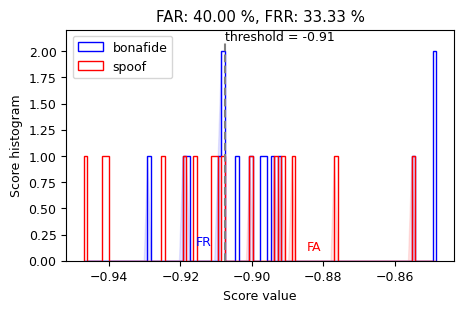

In [ ]:
eer, threshold = compute_eer(np.array(score_bona_list), np.array(score_spf_list))
print(f"EER(\%): {eer*100}")
fig, axis = plot_scores_far_frr(np.array(score_bona_list), np.array(score_spf_list), threshold)

Of course, with 50 iterations with batch size of 1, the model is not trained. Let's load a pre-trained model and test it again.

In [ ]:
!wget --no-check-certificate --content-disposition https://www.dropbox.com/scl/fi/m918ez65gagmpu2pql38k/AASIST-L.pt?rlkey=axz4sroi0ic2tsgpql24lji1h&dl=0
aasistl_weights = torch.load("AASIST-L.pt", map_location=torch.device(device))

model.load_state_dict(aasistl_weights)

--2023-08-15 15:16:55--  https://www.dropbox.com/scl/fi/m918ez65gagmpu2pql38k/AASIST-L.pt?rlkey=axz4sroi0ic2tsgpql24lji1h
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:6021:18::a27d:4112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/e/scl/fi/m918ez65gagmpu2pql38k/AASIST-L.pt?rlkey=axz4sroi0ic2tsgpql24lji1h [following]
--2023-08-15 15:16:55--  https://www.dropbox.com/e/scl/fi/m918ez65gagmpu2pql38k/AASIST-L.pt?rlkey=axz4sroi0ic2tsgpql24lji1h
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc56b60640ff2d9ad111ec0b4aeb.dl.dropboxusercontent.com/cd/0/get/CB3JM3350SAhgzyANFtQVSQAFLOCsQCEzwShiB6eeaCziBUK6_M1kl5tMquisYXL-IYDOeTgYmbRetIOqk5YlpPR1MtDrCTBCD5YZKhjVpJlR_X-n19o6dGBx4a3mGJtoKgH_2lP2P5MpDQ9Q2IeXAlc/file# [following]
--2023-08-15 15:16:56--  https://uc56b60640ff2d9ad111ec0b

<All keys matched successfully>

Evaluate again.

EER(\%): 0.0


<ipython-input-41-fbde25098128>:52: RuntimeWarning: invalid value encountered in divide
  xloc = ((spoof_bins[fa_region] * spoof_counts[fa_region]) / spoof_counts[fa_region].sum()).sum()
<ipython-input-41-fbde25098128>:57: RuntimeWarning: invalid value encountered in divide
  xloc = ((bona_bins[fr_region] * bona_counts[fr_region]) / bona_counts[fr_region].sum()).sum()


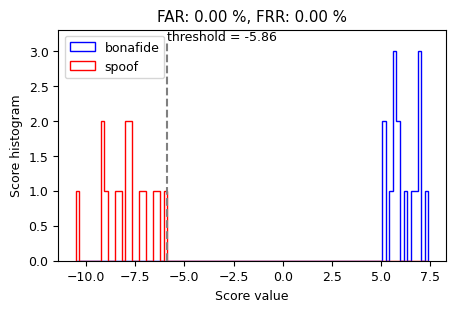

In [ ]:
score_bona_list, score_spf_list, label_bona_list, label_spf_list = test(test_list, model)
eer, threshold = compute_eer(np.array(score_bona_list), np.array(score_spf_list))
print(f"EER(\%): {eer*100}")
fig, axis = plot_scores_far_frr(np.array(score_bona_list), np.array(score_spf_list), threshold)

# Reference

(Leeuwen 2007) David A Van Leeuwen, and Niko Brümmer. An Introduction to Application-Independent Evaluation of Speaker Recognition Systems. In Speaker Classification I, 330–353. Springer. 2007.


(Martin 1997) Alvin Martin, George Doddington, Terri Kamm, Mark Ordowski, and Mark Przybocki. The DET Curve in Assessment of Detection Task Performance. In Proc. Eurospeech, 1895–1898. 1997.

(Kinnunen 2020) Tomi Kinnunen, Hector Delgado, Nicholas Evans, Kong Aik Lee, Ville Vestman, Andreas Nautsch, Massimiliano Todisco, Xin Wang, Md Sahidullah, Junichi Yamagishi, and Douglas A Reynolds. Tandem Assessment of Spoofing Countermeasures and Automatic Speaker Verification: Fundamentals. IEEE/ACM Transactions on Audio, Speech, and Language Processing 28. IEEE: 2195–2210. doi:10.1109/TASLP.2020.3009494. 2020.

(Kirchhübel 2022) Christin Kirchhübel, and Georgina Brown. Spoofed Speech from the Perspective of a Forensic Phonetician. In Proc. Interspeech, 1308–1312. doi:10.21437/Interspeech.2022-661. 2022.


# LICENSE

```
BSD 3-Clause License

Copyright (c) 2023, Jee-weon Jung, Hye-jin Shim, Hemlata Tak, Xin Wang.
All rights reserved.

Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions are met:

1. Redistributions of source code must retain the above copyright notice, this
   list of conditions and the following disclaimer.

2. Redistributions in binary form must reproduce the above copyright notice,
   this list of conditions and the following disclaimer in the documentation
   and/or other materials provided with the distribution.

3. Neither the name of the copyright holder nor the names of its
   contributors may be used to endorse or promote products derived from
   this software without specific prior written permission.

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE
FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL
DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR
SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER
CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY,
OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.
```



# ACKNOWLEDGEMENT

Xin Wang is partially supported by JST CREST VoicePersonae project (JPMJCR18A6) and JSPS KAKENHI Grants (21K17775, 21H04906).





